# Comparing current and collection upgrade Landsat data

**What does this notebook do?** 

This notebook demonstrates how to load matching data from both the current collection and the collection upgrade databases, make both datasets consistent, then conduct some very basic comparisons of values for each band. This is intended to serve as a starting point for more advanced comparisons of the two collections. 

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea` 

This notebook uses external functions `rgb` and `display_map`. These functions is available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** February 2019

**Author:** Robbi Bishop-Taylor

## Database access
Create a config file in your home directory named `.ard-interoperability_tmp.conf` containing the following info:

```
[datacube]
db_hostname: agdcstaging-db.nci.org.au
db_port:     6432
db_database: ard_interop
```    

## Load modules

In [1]:
import datacube 
import xarray as xr
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking

# Connect to current collection and collection upgrade databases
dc_ard = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')
dc = datacube.Datacube()

import sys
sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools

%load_ext autoreload
%autoreload 2


## Set up query and analysis parameters
Here we set a centroid for the area we want to compare, and set up CRS, resolution and resampling that will be applied to both collectiondatasets. The values below extract both collections to match the collection upgrade CRS and resolution (UTM zone 56 S and 30m pixels).

In [2]:
# Centre point of spatial query
lat, lon = -33.7169, 151.2975
time_period = ('2016-01-15', '2016-04-01')

# Desired output resolution and projection for both datasets
output_crs = 'EPSG:28356'
output_resolution = (30, 30)
output_resamp_continuous = 'bilinear'
output_resamp_categorical = 'nearest'

# Bands/measurements to load
collectionupgrade_bands = ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
currentcollection_bands = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2']

# Set up query
query = {'lon': (lon - 0.03, lon + 0.03),
         'lat': (lat - 0.03, lat + 0.03),
         'time': time_period}

# Preview spatial query
DEAPlotting.display_map(x=query['lon'], y=query['lat'], crs='EPSG:4326')


## Load in collection upgrade data

In [3]:
xarray_dict = {}

# Iterate through each sensor
for sensor in ['ls8']:

    # Load data 
    landsat_ds = dc_ard.load(product = f'{sensor}_ard', 
                             measurements = collectionupgrade_bands,
                             output_crs = output_crs,
                             resolution = output_resolution,
                             resampling = output_resamp_continuous,
                             group_by = 'solar_day', 
                             **query)
    
    # Load PQ data seperately (this enables using a different resampling method on 
    # continuous surface reflectance values vs categorical fmask/PQ values)
    landsat_pq = dc_ard.load(product = f'{sensor}_ard', 
                             measurements = ['fmask'],
                             output_crs = output_crs,
                             resolution = output_resolution,
                             resampling = output_resamp_categorical,
                             group_by = 'solar_day', 
                             **query)

    # Identify pixels with valid data: no nodata AND no cloud AND no cloud shadow
    good_quality = ((landsat_pq.fmask != 0) & 
                    (landsat_pq.fmask != 2) & 
                    (landsat_pq.fmask != 3))

    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Add to list
    xarray_dict[sensor] = landsat_ds

# Concatenate multiple sensors into one dataset
landsat_collectionupgrade = xr.concat(xarray_dict.values(), dim='time')
landsat_collectionupgrade = landsat_collectionupgrade.sortby('time')
landsat_collectionupgrade

<xarray.Dataset>
Dimensions:       (time: 4, x: 190, y: 226)
Coordinates:
  * y             (y) float64 6.265e+06 6.265e+06 ... 6.271e+06 6.271e+06
  * x             (x) float64 3.394e+05 3.394e+05 ... 3.45e+05 3.451e+05
  * time          (time) datetime64[ns] 2016-01-30T23:43:46.566317 ... 2016-03-18T23:43:30.965482
Data variables:
    nbart_red     (time, y, x) float64 968.0 853.0 846.0 ... 63.0 65.0 60.0
    nbart_green   (time, y, x) float64 993.0 850.0 826.0 ... 138.0 138.0 135.0
    nbart_blue    (time, y, x) float64 708.0 603.0 588.0 ... 213.0 211.0 206.0
    nbart_nir     (time, y, x) float64 2.39e+03 2.268e+03 ... 45.0 44.0
    nbart_swir_1  (time, y, x) float64 1.896e+03 1.771e+03 ... 36.0 30.0
    nbart_swir_2  (time, y, x) float64 1.39e+03 1.294e+03 ... 31.0 25.0
Attributes:
    crs:      EPSG:28356

## Load in current collection data

In [4]:
xarray_dict = {}

for sensor in ['ls8']:

    # Load data 
    landsat_ds = dc.load(product = f'{sensor}_nbart_albers', 
                         measurements = currentcollection_bands,
                         output_crs = output_crs,
                         resolution = output_resolution,
                         resampling = output_resamp_continuous,
                         group_by = 'solar_day', 
                         **query)

    # Load PQ data 
    landsat_pq = dc.load(product = f'{sensor}_pq_albers', 
                         measurements = ['pixelquality'],
                         output_crs = output_crs,
                         resolution = output_resolution,
                         resampling = output_resamp_categorical,
                         group_by = 'solar_day', 
                         **query)                       

    # Filter to subset of Landsat observations that have matching PQ data 
    time = (landsat_ds.time - landsat_pq.time).time
    landsat_ds = landsat_ds.sel(time=time)
    landsat_pq = landsat_pq.sel(time=time)

    # Create PQ mask
    good_quality = masking.make_mask(landsat_pq.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True) 
    
    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Add result to dict
    xarray_dict[sensor] = landsat_ds

# Concatenate multiple sensors into one dataset
landsat_currentcollection = xr.concat(xarray_dict.values(), dim='time')
landsat_currentcollection = landsat_ds.sortby('time')
landsat_currentcollection

<xarray.Dataset>
Dimensions:  (time: 4, x: 190, y: 226)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-30T23:43:46 ... 2016-03-18T23:43:30.500000
  * y        (y) float64 6.265e+06 6.265e+06 6.265e+06 ... 6.271e+06 6.271e+06
  * x        (x) float64 3.394e+05 3.394e+05 3.395e+05 ... 3.45e+05 3.451e+05
Data variables:
    red      (time, y, x) float64 1.024e+03 895.0 798.0 864.0 ... 68.0 68.0 64.0
    blue     (time, y, x) float64 762.0 645.0 593.0 672.0 ... 229.0 226.0 223.0
    green    (time, y, x) float64 1.019e+03 863.0 796.0 ... 137.0 139.0 135.0
    nir      (time, y, x) float64 2.54e+03 2.358e+03 2.43e+03 ... 56.0 55.0 52.0
    swir1    (time, y, x) float64 1.954e+03 1.764e+03 1.679e+03 ... 37.0 33.0
    swir2    (time, y, x) float64 1.447e+03 1.35e+03 1.282e+03 ... 30.0 26.0
Attributes:
    crs:      EPSG:28356

## Make both datasets consistent
Both collections have different band names and slightly different time stamps. Here we make both consistent so they can be analysed more easily in xarray:

In [5]:
# Round both dataset timestamps to daily because both datasets have different timestamps
landsat_collectionupgrade.coords['time'] = landsat_collectionupgrade.time.astype('datetime64[D]')
landsat_currentcollection.coords['time'] = landsat_currentcollection.time.astype('datetime64[D]')

# Rename current collection bands to match collection upgrade
band_rename_dict = {'red': 'nbart_red', 'green':'nbart_green', 'blue': 'nbart_blue',
                    'nir': 'nbart_nir', 'swir1': 'nbart_swir_1', 'swir2': 'nbart_swir_2'}
landsat_currentcollection.rename(band_rename_dict, inplace=True)
landsat_currentcollection

<xarray.Dataset>
Dimensions:       (time: 4, x: 190, y: 226)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-30 2016-02-15 ... 2016-03-18
  * y             (y) float64 6.265e+06 6.265e+06 ... 6.271e+06 6.271e+06
  * x             (x) float64 3.394e+05 3.394e+05 ... 3.45e+05 3.451e+05
Data variables:
    nbart_red     (time, y, x) float64 1.024e+03 895.0 798.0 ... 68.0 68.0 64.0
    nbart_blue    (time, y, x) float64 762.0 645.0 593.0 ... 229.0 226.0 223.0
    nbart_green   (time, y, x) float64 1.019e+03 863.0 796.0 ... 139.0 135.0
    nbart_nir     (time, y, x) float64 2.54e+03 2.358e+03 2.43e+03 ... 55.0 52.0
    nbart_swir_1  (time, y, x) float64 1.954e+03 1.764e+03 ... 37.0 33.0
    nbart_swir_2  (time, y, x) float64 1.447e+03 1.35e+03 ... 30.0 26.0
Attributes:
    crs:      EPSG:28356

## Plot both datasets

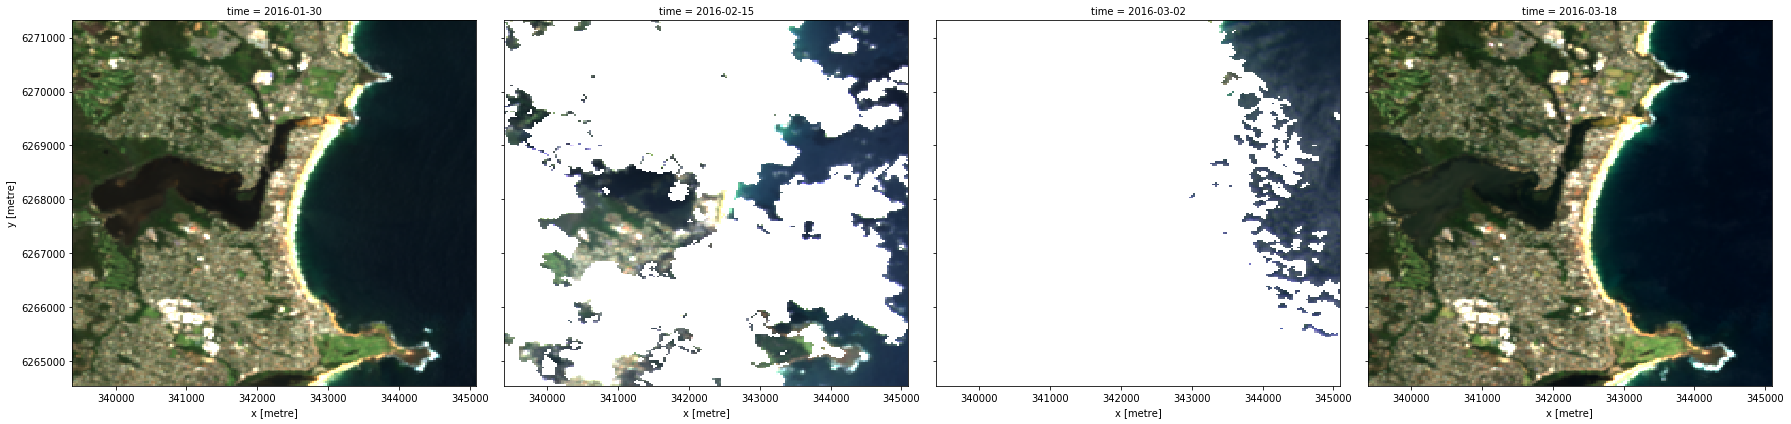

In [6]:
DEAPlotting.rgb(landsat_currentcollection, bands=['nbart_red', 'nbart_green', 'nbart_blue'], col='time')

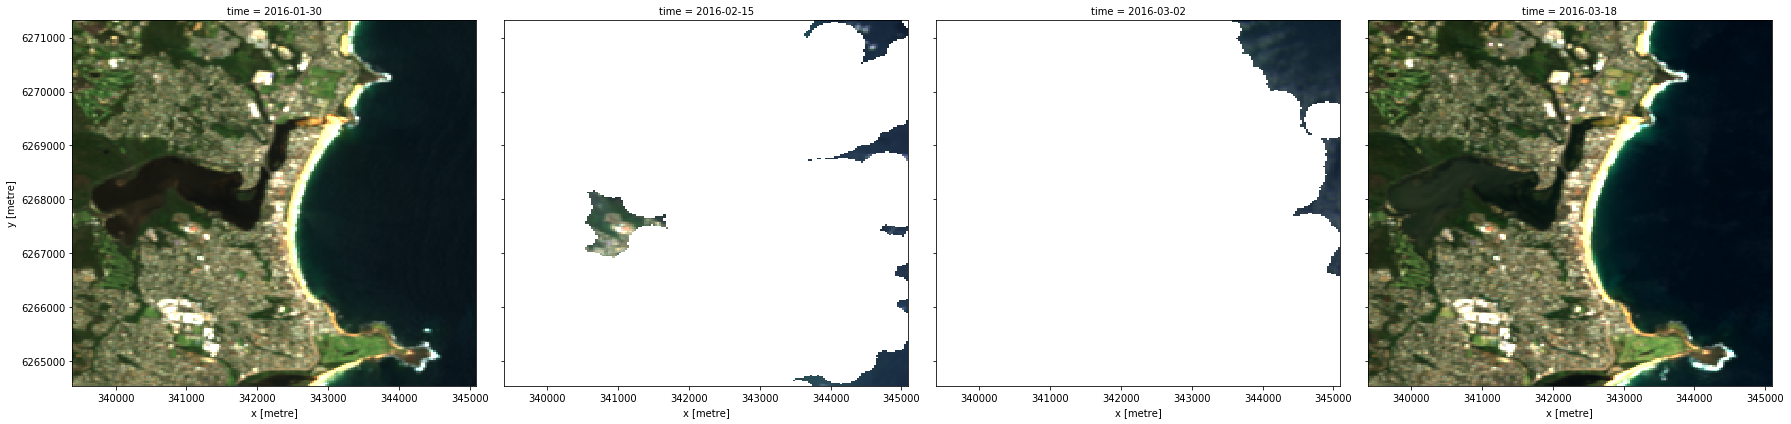

In [7]:
DEAPlotting.rgb(landsat_collectionupgrade, bands=['nbart_red', 'nbart_green', 'nbart_blue'], col='time')

## Compute differences

In [8]:
# Subtract collection upgrade 
collection_diffs = landsat_currentcollection - landsat_collectionupgrade

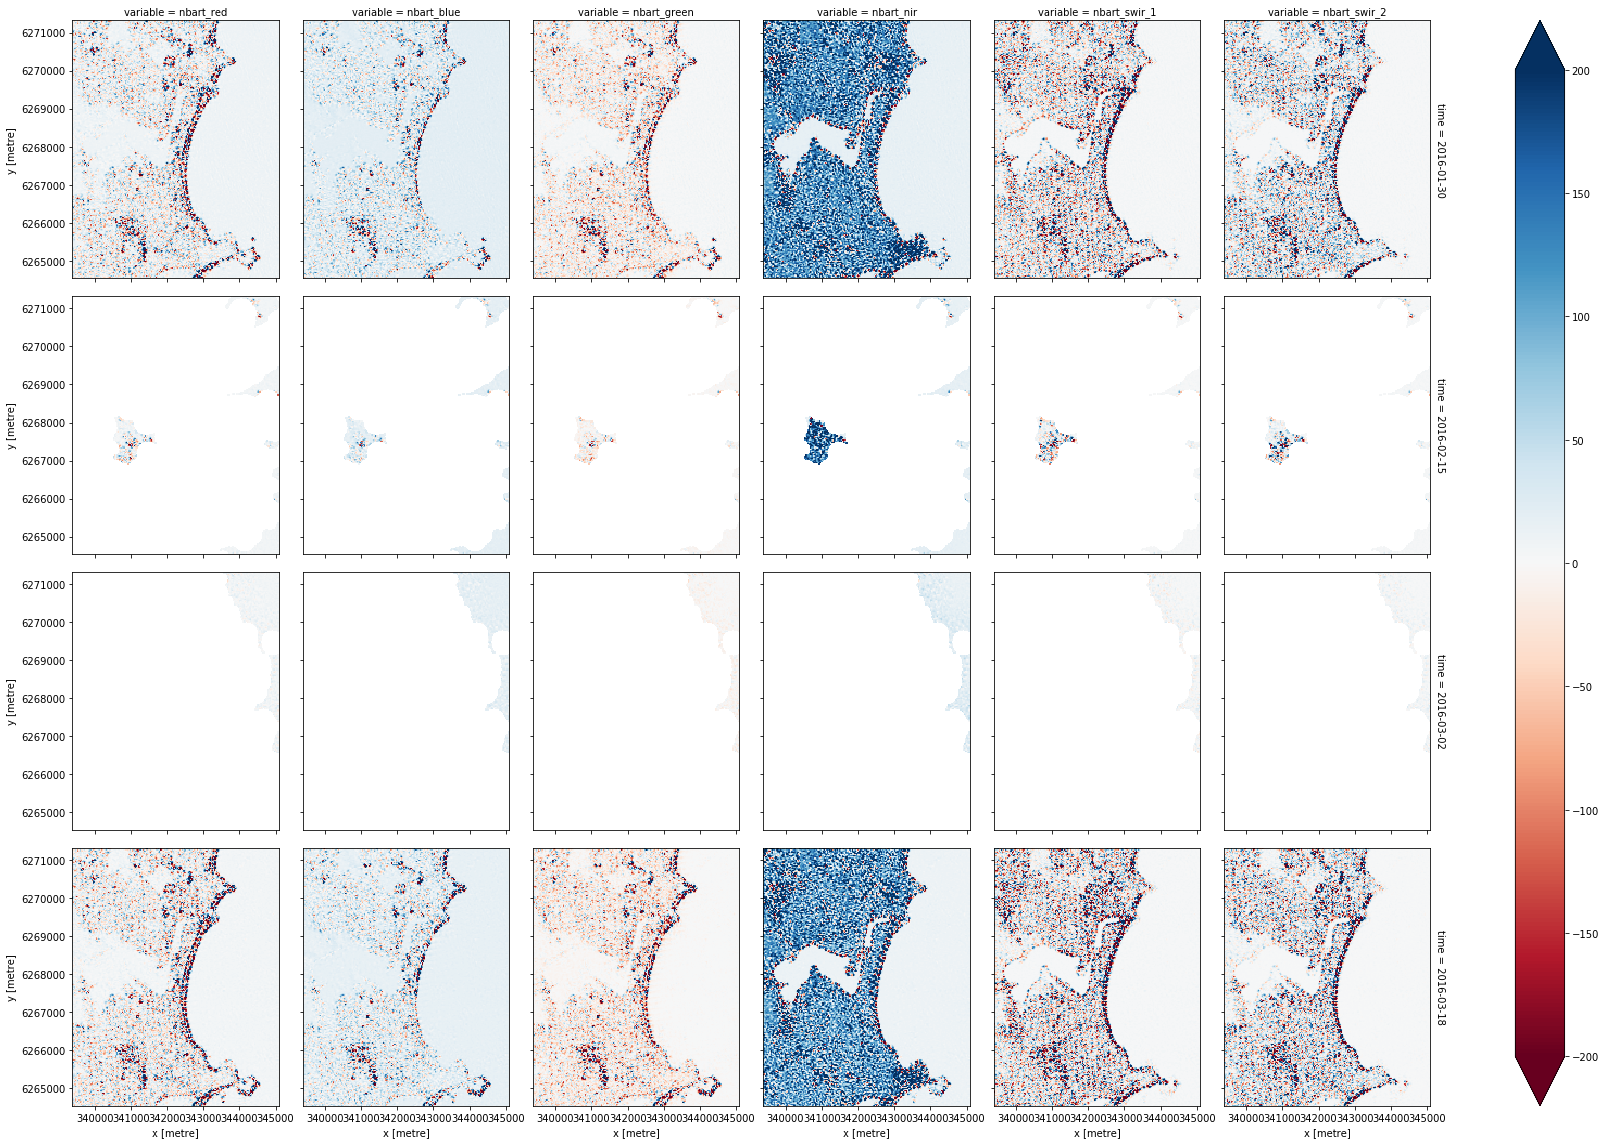

In [9]:
# Plot differences for each band
collection_diffs.to_array().plot(col='variable', row='time', size=4, vmin=-200, vmax=200, cmap='RdBu', aspect=1)